# MultiClass Obesity Risk Prediction

[**Kaggle Competition**](https://www.kaggle.com/competitions/playground-series-s4e2/overview)

**author:** Santanu K.

**Date:** 1st Feb, 2024

## Data Downloading Importing Libraries

In [1]:
# @title Kaggle Competition Data Downloading  { display-mode: "form",run :"auto" }
# @markdown Put the competition name

project_name = 'playground-series-s4e2'  # @param {type: "string"}

def initial_setup():
    from google.colab import userdata
    import os
    token = {"username":userdata.get("Kaggle_Username"),"key":userdata.get("Kaggle")}
    import os, json
    os.environ['KAGGLE_CONFIG_DIR']='.'
    with open('kaggle.json', "w") as f:
        json.dump(token, f)
    !chmod 600 ./kaggle.json
    os.environ['MLFLOW_TRACKING_PASSWORD'] = userdata.get('MLFLOW_TRACKING_PASSWORD')
    os.environ['MLFLOW_TRACKING_USERNAME'] = userdata.get('MLFLOW_TRACKING_USERNAME')

def download_data(project_name=project_name):
    initial_setup()
    from IPython import display
    !kaggle competitions download -c $project_name
    project_name += ".zip"
    !unzip $project_name && rm $project_name
    display.clear_output()
    print("Files have been downloaded!")


In [2]:
download_data()
!kaggle datasets download ankurbajaj9/obesity-levels
!unzip obesity-levels.zip
!rm *.zip *.arff

Files have been downloaded!
  0% 0.00/115k [00:00<?, ?B/s]
100% 115k/115k [00:00<00:00, 51.0MB/s]
Archive:  obesity-levels.zip
  inflating: ObesityDataSet_raw_and_data_sinthetic.arff  
  inflating: ObesityDataSet_raw_and_data_sinthetic.csv  


In [3]:
from IPython import display
from google.colab import output
# output.enable_custom_widget_manager()
# !jupyter nbextension enable --py widgetsnbextension

!pip install optuna-dashboard optuna
!pip install catboost
!pip install tpot
!pip install mlflow dagshub
!mkdir -p output/models
display.clear_output()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson,kstest, shapiro
from IPython.display import Audio,display as dis
from IPython.display import clear_output
import os
import optuna

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (confusion_matrix, accuracy_score,
                             precision_score, f1_score, recall_score,
                             classification_report,
                             roc_auc_score, roc_curve, auc
                             )

In [5]:
from tpot.builtins import StackingEstimator
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.pipeline import make_pipeline

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import VALID_METRICS

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, ExtraTreesClassifier,
                              BaggingClassifier, RandomForestClassifier,
                              GradientBoostingClassifier,
                              HistGradientBoostingClassifier,
                              StackingClassifier
                              )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier

In [7]:
# plotly libraries setup
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "colab"
# import plotly.offline as pyo
# pyo.init_notebook_mode()

In [ ]:
import dagshub
import mlflow
initial_setup()
dagshub.init("Kaggle-Competitions-Lab", "SantanuK", mlflow=True)
experiment_name = 'Multiclass Obesity Prediction'

try:
    mlflow.create_experiment(experiment_name)
    print("Successfully created")
    mlflow.set_experiment(experiment_name)
except Exception as e:
    mlflow.set_experiment(experiment_name)
    print("Experiment has been created or some issue occured!\n")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=bfe0e07c-d843-4820-bce5-3f3a7a1f15c5&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=9e2c0ccc6d219879a032745e10b988d6283bd218c79d58db89ff7aa7331bba6d




Initialized MLflow to track repo "SantanuK/Kaggle-Competitions-Lab"

Repository initialized!

Experiment has been created or some issue occured!



## Data Loading

In [8]:
num_features = ['Age', 'Height', 'Weight', ]
cat_features = ['Gender', 'family_history_with_overweight', 'FAVC',
                'FCVC','NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC',
                'FAF', 'TUE', 'CALC', 'MTRANS'
                ]
target_feature = 'NObeyesdad'

In [9]:
df_train = pd.read_csv('train.csv')
df_train.pop('id')

df_extra = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')

df_test = pd.read_csv('test.csv')

In [10]:
for i in ['Age', 'FCVC', 'NCP', 'CH2O','FAF','TUE']:
    df_train[i] = df_train[i].round(0).astype(int)
    df_extra[i] = df_extra[i].round(0).astype(int)
    df_test[i]  = df_test[i].round(0).astype(int)

for i in ['Weight', 'Height']:
    df_train[i] = df_train[i].round(2)
    df_extra[i] = df_extra[i].round(2)
    df_test[i]  = df_test[i].round(2)


df_total = pd.concat([df_train,df_extra]).drop_duplicates().reset_index(drop=True)

## List of Functions

## Data Visualization

**About the dataset:**
1. Frequent consumption of high caloric food (FAVC)
1. Frequency of consumption of vegetables(FCVC)
1. Number of main meals (NCP)
1. Consumption of food between meals (CAEC)
1. Consumption of water daily (CH2O)
1. Calories consumption monitoring (SCC)
1. Physical activity frequency (FAF)
1. Time using technology devices (TUE)
1. Consumption of alcohol (CALC)
1. Transportation used (MTRANS)


**Further readings:**
1. https://doi.org/10.1101/2022.08.17.22278905
1. https://github.com/PriyankaSett/obesity_multiclassification/blob/main/Q.2.ipynb
1. https://github.com/Soothysay/HybridObe/blob/main/untitled0.py


In [ ]:
df_train.head()

Gender        Age    Height      Weight family_history_with_overweight  \
0    Male  24.443011  1.699998   81.669950                            yes   
1  Female  18.000000  1.560000   57.000000                            yes   
2  Female  18.000000  1.711460   50.165754                            yes   
3  Female  20.952737  1.710730  131.274851                            yes   
4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE       CALC                 MTRANS           NObeyesdad  
0  0.976473  Sometimes  Public_Transportation  Overweight_Level_II  
1  1.000000         no             Automobile        Normal_Weight  
2  1.673584         no  Public_Transportation  Insufficient_Weight  
3  0.780199  Sometimes  Public_Transportation     Obesity_Type_III  
4  0.931721  Sometimes  Public_Transportation  Overweight_Level_II

In [ ]:
df_extra.head()

Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        Normal_Weight  
3                Walking   Overweight_Level_I  
4  Public_Transportation  Overweight_Level_II

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

In [ ]:
df_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13840 non-null  int64  
 1   Gender                          13840 non-null  object 
 2   Age                             13840 non-null  float64
 3   Height                          13840 non-null  float64
 4   Weight                          13840 non-null  float64
 5   family_history_with_overweight  13840 non-null  object 
 6   FAVC                            13840 non-null  object 
 7   FCVC                            13840 non-null  float64
 8   NCP                             13840 non-null  float64
 9   CAEC                            13840 non-null  object 
 10  SMOKE                           13840 non-null  object 
 11  CH2O                            13840 non-null  float64
 12  SCC                             

### Preprocessing-1:

In [11]:
for i in ['Age', 'FCVC', 'NCP', 'CH2O','FAF','TUE']:
    df_train[i] = df_train[i].round(0).astype(int)
    df_extra[i] = df_extra[i].round(0).astype(int)
    df_test[i]  = df_test[i].round(0).astype(int)

for i in ['Weight', 'Height']:
    df_train[i] = df_train[i].round(2)
    df_extra[i] = df_extra[i].round(2)
    df_test[i]  = df_test[i].round(2)


### Seggreagating numerical and categorical columns

In [12]:
"""
This represents the number of unique values in each features
for train, test, extra dataset
"""
temp = pd.DataFrame([], columns = ['Features','Train', 'Extra', 'Test'])
for i, col in enumerate(df_train.columns[:-1]):
    temp.loc[len(temp.index)] = [col, df_train[col].nunique(), df_extra[col].nunique(),
                             df_test[col].nunique()]
temp

Features  Train  Extra  Test
0                           Gender      2      2     2
1                              Age     42     40    39
2                           Height     51     51    52
3                           Weight   1637   1335  1506
4   family_history_with_overweight      2      2     2
5                             FAVC      2      2     2
6                             FCVC      3      3     3
7                              NCP      4      4     4
8                             CAEC      4      4     4
9                            SMOKE      2      2     2
10                            CH2O      3      3     3
11                             SCC      2      2     2
12                             FAF      4      4     4
13                             TUE      3      3     3
14                            CALC      3      4     4
15                          MTRANS      5      5     5

In [13]:
num_features = ['Age', 'Height', 'Weight', ]
cat_features = ['Gender', 'family_history_with_overweight', 'FAVC',
                'FCVC','NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC',
                'FAF', 'TUE', 'CALC', 'MTRANS'
                ]
target_feature = 'NObeyesdad'

In [ ]:
len(num_features)+len(cat_features)+1

17

### Get the values of each categorical columns

In [ ]:
"""
This represents unique values in each features
for train, test, extra dataset
"""
temp = pd.DataFrame([], columns = ['Features','Train', 'Extra', 'Test'])
make_string = lambda x: ", ".join(list(x.unique().astype(str)))
for i, col in enumerate(cat_features):
    temp.loc[len(temp.index)] = [col, make_string(df_train[col]),
                                 make_string(df_extra[col]),
                                 make_string(df_test[col])]
temp

Features  \
0                           Gender   
1   family_history_with_overweight   
2                             FAVC   
3                             FCVC   
4                              NCP   
5                             CAEC   
6                            SMOKE   
7                             CH2O   
8                              SCC   
9                              FAF   
10                             TUE   
11                            CALC   
12                          MTRANS   

                                                Train  \
0                                        Male, Female   
1                                             yes, no   
2                                             yes, no   
3                                             2, 3, 1   
4                                          3, 1, 2, 4   
5                   Sometimes, Frequently, no, Always   
6                                             no, yes   
7                                             3, 2, 1   
8                                             no, yes   
9                                          0, 1, 2, 3   
10                                            1, 2, 0   
11                          Sometimes, no, Frequently   
12  Public_Transportation, Automobile, Walking, Mo...   

                                                Extra  \
0                                        Female, Male   
1                                             yes, no   
2                                             no, yes   
3                                             2, 3, 1   
4                                          3, 1, 4, 2   
5                   Sometimes, Frequently, Always, no   
6                                             no, yes   
7                                             2, 3, 1   
8                                             no, yes   
9                                          0, 3, 2, 1   
10                                            1, 0, 2   
11                  no, Sometimes, Frequently, Always   
12  Public_Transportation, Walking, Automobile, Mo...   

                                                 Test  
0                                        Male, Female  
1                                             yes, no  
2                                             yes, no  
3                                             3, 2, 1  
4                                          3, 1, 4, 2  
5                   Sometimes, Always, Frequently, no  
6                                             no, yes  
7                                             3, 1, 2  
8                                             no, yes  
9                                          1, 0, 2, 3  
10                                            0, 1, 2  
11                  Sometimes, no, Frequently, Always  
12  Public_Transportation, Automobile, Walking, Bi...

### Visualization of columns

#### Select your dataframe

In [ ]:
df= df_extra.copy()

#### Description of data

In [ ]:
df.describe(include=['O'])

Gender family_history_with_overweight  FAVC       CAEC SMOKE   SCC  \
count    2111                           2111  2111       2111  2111  2111   
unique      2                              2     2          4     2     2   
top      Male                            yes   yes  Sometimes    no    no   
freq     1068                           1726  1866       1765  2067  2015   

             CALC                 MTRANS      NObeyesdad  
count        2111                   2111            2111  
unique          4                      5               7  
top     Sometimes  Public_Transportation  Obesity_Type_I  
freq         1401                   1580             351

In [ ]:
df.describe()

Age       Height       Weight         FCVC          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.315964     1.701620    86.586035     2.423496     2.687826   
std       6.357078     0.093368    26.191163     0.583905     0.809680   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      20.000000     1.630000    65.470000     2.000000     3.000000   
50%      23.000000     1.700000    83.000000     2.000000     3.000000   
75%      26.000000     1.770000   107.430000     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  2111.000000  2111.000000  2111.000000  
mean      2.014685     1.006632     0.664614  
std       0.688616     0.895462     0.674009  
min       1.000000     0.000000     0.000000  
25%       2.000000     0.000000     0.000000  
50%       2.000000     1.000000     1.000000  
75%       2.000000     2.000000     1.000000  
max       3.000000     3.000000     2.000000

#### Distribution of target

In [ ]:
# visualization  of target feature column
fig = px.histogram(df, x = target_feature, histnorm='probability density')
fig.update_layout(bargap=.2, title = f"Histogram plot for target variable {target_feature}")
fig.show()

In [ ]:
fig = px.histogram(df, x = target_feature,color='Gender', histnorm='probability density',)
fig.update_layout(barmode='group',bargap=.2, title = f"Histogram plot for target variable {target_feature}")
fig.show()

#### Distribution of categorical features

In [ ]:
r, c = 5, 3
fig = make_subplots(rows=r, cols=c)

for i, col in enumerate(cat_features):
    trace = go.Histogram(x=df[col], name=col)
    fig.append_trace(trace, (i//c)+1, (i%c)+1)

fig.update_layout(bargap=.2, title= "Histogram of Categorical features", height=800)
fig.show()

In [ ]:
r, c = 5, 3
fig = make_subplots(rows=r, cols=c)

for i, col in enumerate(cat_features):
    trace = go.Histogram(x=df[col], name=col, histnorm='probability density',
                         texttemplate="%{y:.2f}")
    fig.append_trace(trace, (i//c)+1, (i%c)+1)

fig.update_layout(bargap=.2, title= "Histogram of Categorical features", height=800)
fig.show()

In [ ]:
c = 4
r = len(cat_features)//c + 1 if(len(cat_features)%c!=0) else 0
fig = make_subplots(rows=r, cols=c, specs=[[{'type':'domain'}]*c]*r)

for i, col in enumerate(cat_features):
    category_counts = df[col].value_counts()
    labels = category_counts.index
    values = category_counts.values
    trace = go.Pie(labels =labels, values=values, name=col,
                        #  texttemplate="%{values:.2f}"
                )
    fig.append_trace(trace, (i//c)+1, (i%c)+1)

fig.update_layout(title= "Pie Chart of Categorical features", height=200*r, width=300*c)
fig.show()

#### Histogram of cross categorical features

In [ ]:
for i, col in enumerate(cat_features):
    fig = px.histogram(df,x=col, color=target_feature, histnorm='probability density')
    fig.update_layout(barmode='group',bargap=.2,title=f'Histogram of {col}')
    fig.show()

#### Distribution of numerical features

In [ ]:
r, c = 3, 1
fig = make_subplots(rows=r, cols=c)

for i, col in enumerate(num_features):
    trace = go.Histogram(x=df[col], name=col,
                        #  histnorm='probability',
                         texttemplate="%{y:.1f}")
    fig.append_trace(trace, (i//c)+1, (i%c)+1)

fig.update_layout(bargap=.2, title= "Histogram of Numerical features", height=800)
fig.show()

#### Boxplot of numerical features

In [ ]:
fig = make_subplots(rows=1, cols=3, subplot_titles = num_features)
for i,col in enumerate(num_features):
    trace = go.Box(y=df[col], name=col)
    fig.append_trace(trace,row=1,col=i+1)
fig.update_layout(title="Boxplot of numerical columns")
fig.show()

In [ ]:
fig = make_subplots(rows=3, cols=1, subplot_titles = num_features)
for i,col in enumerate(num_features):
    trace = go.Box(x=df[target_feature],y=df[col], name=col)
    fig.append_trace(trace,row=i+1,col=1)
fig.update_layout(title="Boxplot of numerical columns acccross target feature",height=800)
fig.show()

#### Violin plot of numerical features

In [ ]:
fig = make_subplots(rows=1, cols=3, subplot_titles = num_features)
for i,col in enumerate(num_features):
    trace = go.Violin(y=df[col], box_visible=True, name=col)
    fig.append_trace(trace,row=1,col=i+1)
fig.update_layout(title="Boxplot of numerical columns")
fig.show()

In [ ]:
fig = make_subplots(rows=3, cols=1, subplot_titles = num_features)
for i,col in enumerate(num_features):
    trace = go.Violin(x=df[target_feature],y=df[col], box_visible=False, name=col)
    fig.append_trace(trace,row=i+1,col=1)
fig.update_layout(title="Boxplot of numerical columns acccross target feature",height=800, width=1200)
fig.show()

#### Correlation plot

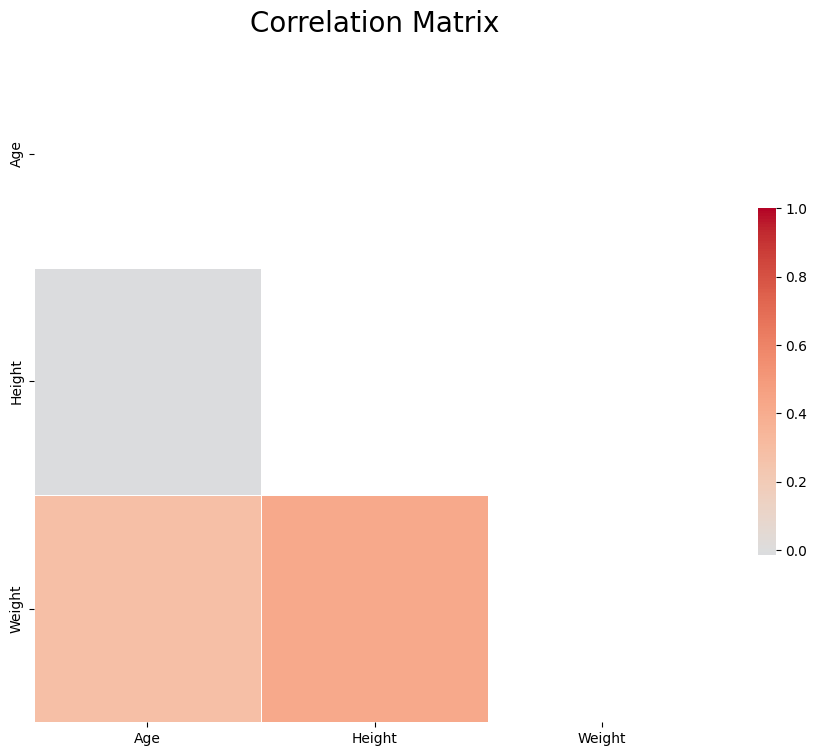

In [ ]:
corr = df[num_features].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix', fontsize=20)
plt.savefig("output/Correlation matrix.png")
plt.show()

### $\chi^2$ for categorical features vs target feature

$H_0$ : The categorical feature and taget feature are distributed independently.

In [ ]:
df = df_extra.copy()

In [ ]:
from scipy.stats import chi2_contingency
temp = pd.DataFrame([], columns = ['Feature', 'Test Statistic', 'P Value', 'Rejected'])
threshold = 0.05
for i, col in enumerate(cat_features):
    res = chi2_contingency(pd.crosstab(df[col], df[target_feature]))
    temp.loc[i] = [col, round(res.statistic,3), round(res.pvalue,3), res.pvalue<threshold]
temp

Feature  Test Statistic  P Value  Rejected
0                           Gender         657.746      0.0      True
1   family_history_with_overweight         621.979      0.0      True
2                             FAVC         233.341      0.0      True
3                             FCVC         566.930      0.0      True
4                              NCP         487.989      0.0      True
5                             CAEC         802.977      0.0      True
6                            SMOKE          32.138      0.0      True
7                             CH2O         163.319      0.0      True
8                              SCC         123.024      0.0      True
9                              FAF         273.709      0.0      True
10                             TUE         177.636      0.0      True
11                            CALC         338.578      0.0      True
12                          MTRANS         292.594      0.0      True

### ANOVA testing

Assumption:
1. Age, weight, height are normally distributed.

**ANOVA test**

$H_0$ : The population mean of all of the groups are equal.

**The Kruskal-Wallis H-test**

$H_0$ : The population median of all of the groups are equal.

In [ ]:
from scipy.stats import f_oneway, kruskal
temp = pd.DataFrame()
temp['Feature'] = num_features
groups = []
for i in df[target_feature].unique():
    groups.append(df[df[target_feature]==i][num_features])
F, p = f_oneway(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6] )
temp['Anova_stats'] = np.round(F,3)
temp['Anova_pvalue'] = np.round(p,3)
F, p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6] )
temp['Krushkal_stats'] = np.round(F,3)
temp['Krushkal_pvalue'] = np.round(p,3)
temp

Feature  Anova_stats  Anova_pvalue  Krushkal_stats  Krushkal_pvalue
0     Age       78.163           0.0         546.106              0.0
1  Height       38.502           0.0         218.263              0.0
2  Weight     1966.491           0.0        1822.174              0.0

### Summary:

1. All features of `num_features` and `col_features` will be our feature.
1.

## New features extraction

In [ ]:
"""
# 1. Interaction Terms
        data['Weight_Age'] = data['Weight'] * data['Age']

        # 2. Polynomial Features
        poly = PolynomialFeatures(degree=2, include_bias=False)
        poly_features = poly.fit_transform(data[['Weight', 'Age']])
        poly_columns = [f'Poly_{i}' for i in range(poly_features.shape[1])]
        data[poly_columns] = pd.DataFrame(poly_features, columns=poly_columns)

        # 3. BMI (Body Mass Index)
        data['BMI'] = data['Weight'] / (data['Height'] ** 2)

        # 4. Age Groups
        bins = [0, 18, 30, 45, 60, np.inf]
        labels = ['0-18', '18-30', '30-45', '45-60', '60+']
        data['Age_Group'] = pd.cut(data['Age'], bins=bins, labels=labels)
        data['Age_Group'] = data['Age_Group'].cat.codes

        bins = [0, 150, 160, 170, 180, np.inf]
        height_labels = ['0-150', '150-160', '160-170', '170-180', '180+']
        data['Height_Group'] = pd.cut(data['Height'], bins=bins, labels=height_labels)
        data['Height_Group'] = data['Height_Group'].cat.codes

        # 5. Height-related Ratios
        data['Weight_Height_Ratio'] = data['Weight'] / data['Height']
        data['Age_Height_Ratio'] = data['Age'] / data['Height']
        data['Height_Age_Product'] = data['Height'] * data['Age']

        ##Source:::https://www.kaggle.com/competitions/playground-series-s4e2/discussion/476939
        # Calculate waist area
        density = 985
        data['waist_area'] = data['Weight'] * data['Height'] * (1 / density)
        # Calculate waist circumference
        data['waist_circumference'] = 2 * np.sqrt(data['waist_area'] / np.pi) * np.pi


        categorical_cols = ['family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
        for col in categorical_cols:
            data[f'Mean_{col}_Weight'] = data.groupby(col)['Weight'].transform('mean')
            data[f'Median_{col}_Age'] = data.groupby(col)['Age'].transform('median')

        return data

"""

## Preprocessing

### Preprocessing order-1

In [14]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline(steps=[('scaler', MinMaxScaler())])
cat_pipeline = Pipeline(steps=[('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=5))])
preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_features),
    ('cat_pipeline', cat_pipeline, cat_features),
])

In [ ]:
num_pipeline = Pipeline(steps=[('scaler', MinMaxScaler())])
cat_pipeline = Pipeline(steps=[('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=5))])
preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_features),
    ('cat_pipeline', cat_pipeline, cat_features),
])

### Preprocessing order-2

In [ ]:
num_pipeline = Pipeline(steps=[('scaler', RobustScaler())])
cat_pipeline = Pipeline(steps=[
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=4)),
     ('scaler', RobustScaler())
     ])
preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_features),
    ('cat_pipeline', cat_pipeline, cat_features),
])

## CatBoost

In [ ]:
from catboost import Pool
df = df_train.copy()
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(target_feature, axis=1),
                                                    df[target_feature],test_size=.3)
train_pool = Pool(X_train, Y_train, cat_features=cat_features)
test_pool = Pool(X_test, Y_test, cat_features=cat_features)

# we need to use eval_metric, od_pval to detect overfitting
# cbc = CatBoostClassifier(od_pval=1e-10,eval_metric = 'Accuracy',cat_features=cat_features,random_state=42)
cbc = CatBoostClassifier(
                            od_pval=1e-2,
                            # early_stopping_rounds=10,
                            iterations = 1200,
                            learning_rate=.08,
                            loss_function='MultiClass',
                            custom_metric = 'Accuracy',
                            eval_metric = 'Accuracy',
                            cat_features=cat_features,random_state=42)
output.enable_custom_widget_manager()
cbc.fit(train_pool, eval_set=test_pool, metric_period=10, plot=True, verbose=50)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7394357	test: 0.7308927	best: 0.7308927 (0)	total: 881ms	remaining: 17m 36s
50:	learn: 0.8750860	test: 0.8604689	best: 0.8611111 (46)	total: 27s	remaining: 10m 8s
100:	learn: 0.8937371	test: 0.8773282	best: 0.8773282 (100)	total: 52.9s	remaining: 9m 35s
150:	learn: 0.9035788	test: 0.8863198	best: 0.8863198 (150)	total: 1m 18s	remaining: 9m 2s
200:	learn: 0.9085341	test: 0.8888889	best: 0.8888889 (198)	total: 1m 43s	remaining: 8m 34s
250:	learn: 0.9113558	test: 0.8916185	best: 0.8916185 (250)	total: 2m 9s	remaining: 8m 11s
300:	learn: 0.9140399	test: 0.8919396	best: 0.8930636 (285)	total: 2m 38s	remaining: 7m 52s
350:	learn: 0.9165864	test: 0.8916185	best: 0.8930636 (285)	total: 3m 3s	remaining: 7m 23s
400:	learn: 0.9188575	test: 0.8912974	best: 0.8930636 (285)	total: 3m 31s	remaining: 7m 1s
450:	learn: 0.9202340	test: 0.8921002	best: 0.8930636 (285)	total: 4m 3s	remaining: 6m 44s
500:	learn: 0.9219546	test: 0.8922608	best: 0.8930636 (285)	total: 4m 28s	remaining: 6m 14s
550

In [ ]:
cbc.plot_tree(tree_idx=990, pool=train_pool)

In [ ]:
pred = cbc.predict(df_train.drop(target_feature, axis=1))
train_report = classification_report(df_train[target_feature], pred)
train_matrix = confusion_matrix(df_train[target_feature], pred)
print(train_report)
print(train_matrix)

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.96      0.94      2523
      Normal_Weight       0.90      0.88      0.89      3082
     Obesity_Type_I       0.91      0.90      0.90      2910
    Obesity_Type_II       0.96      0.98      0.97      3248
   Obesity_Type_III       1.00      1.00      1.00      4046
 Overweight_Level_I       0.83      0.81      0.82      2427
Overweight_Level_II       0.84      0.85      0.84      2522

           accuracy                           0.92     20758
          macro avg       0.91      0.91      0.91     20758
       weighted avg       0.92      0.92      0.92     20758

[[2410  106    1    1    0    3    2]
 [ 168 2703    1    0    0  188   22]
 [   2    3 2619   93    9   54  130]
 [   0    0   52 3181    0    0   15]
 [   1    0    2    4 4036    3    0]
 [  12  154   50    0    0 1973  238]
 [   2   32  164   18    0  170 2136]]


In [ ]:
pred = cbc.predict(df_extra.drop(target_feature, axis=1))
test_report = classification_report(df_extra[target_feature], pred)
test_matrix = confusion_matrix(df_extra[target_feature], pred)
print(test_report)
print(test_matrix)

                     precision    recall  f1-score   support

Insufficient_Weight       0.97      0.99      0.98       272
      Normal_Weight       0.96      0.84      0.89       287
     Obesity_Type_I       0.95      0.93      0.94       351
    Obesity_Type_II       0.92      0.99      0.96       297
   Obesity_Type_III       1.00      0.99      1.00       324
 Overweight_Level_I       0.84      0.91      0.87       290
Overweight_Level_II       0.92      0.89      0.91       290

           accuracy                           0.94      2111
          macro avg       0.94      0.94      0.93      2111
       weighted avg       0.94      0.94      0.94      2111

[[269   3   0   0   0   0   0]
 [  8 240   0   0   0  35   4]
 [  0   0 327  18   0   0   6]
 [  0   0   1 295   1   0   0]
 [  0   0   1   1 322   0   0]
 [  0   8   6   0   0 264  12]
 [  0   0  10   5   0  16 259]]


In [ ]:
import pickle
filename = 'output/models/cat_model_2.pkl'
with open(filename,'wb') as f:
    pickle.dump(cbc,f)

In [ ]:
beatify_matrix = lambda x: '\n'.join(['|'.join([str(cell) for cell in row])+"|" for row in x])+'\n'
beatify_matrix(train_matrix)

'2392|122|0|1|0|6|2|\n182|2696|2|0|0|179|23|\n3|2|2586|93|12|46|168|\n0|0|73|3157|0|1|17|\n1|0|3|4|4035|3|0|\n15|186|50|0|0|1895|281|\n0|35|180|17|0|185|2105|\n'

In [ ]:
description =f"""
cbc = CatBoostClassifier(
                            od_pval=1e-2,
                            # early_stopping_rounds=10,
                            # learning_rate=.01,
                            loss_function='MultiClass',
                            eval_metric = 'Accuracy',
                            cat_features=cat_features,random_state=42)
cbc.fit(train_pool, eval_set=test_pool, metric_period=10, plot=True, verbose=50)

Train:
{train_report}
Insufficient_Weight|Normal_Weight|Obesity_Type_I|Obesity_Type_II|Obesity_Type_III|Overweight_Level_I| Overweight_Level_II|
-------------------|-------------|--------------|---------------|----------------|------------------|--------------------|
{beatify_matrix(train_matrix)}
Test:
{test_report}
Insufficient_Weight|Normal_Weight|Obesity_Type_I|Obesity_Type_II|Obesity_Type_III|Overweight_Level_I| Overweight_Level_II|
-------------------|-------------|--------------|---------------|----------------|------------------|--------------------|
{beatify_matrix(test_matrix)}
"""
with mlflow.start_run(description=description):
    mlflow.log_artifact(filename)

In [ ]:
def objective(trial):
    params ={
        'iterations'    : trial.suggest_int('iterations', 100, 800, log=True),
        'learning_rate' : trial.suggest_float('learning_rate', .01, .1, log=True),
        'reg_lambda'    : trial.suggest_float('reg_lambda', .001, .1, log=True),
        'reg_lambda'    : trial.suggest_float('reg_lambda', .001, .1, log=True),
    }

## Decision Tree Classifier

In [ ]:
num_pipeline = Pipeline(steps=[('scaler', RobustScaler())])
cat_pipeline = Pipeline(steps=[('encoder', OrdinalEncoder()), ('scaler', RobustScaler())])
preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_features),
    ('cat_pipeline', cat_pipeline, cat_features),
])

In [ ]:
from sklearn.tree import export_graphviz
df = df_extra.copy()
dt = DecisionTreeClassifier(random_state=42)

In [ ]:
df_processed = pd.DataFrame(preprocessor.fit_transform(df.drop(target_feature,axis=1)), columns = df.columns[:-1])
dt.fit(df_processed, df[target_feature])

DecisionTreeClassifier(random_state=42)

In [ ]:
def print_model_result(model):
    pred = model.predict(preprocessor.transform(df_train.drop(target_feature, axis=1)))
    train_report = classification_report(df_train[target_feature], pred)
    train_matrix = confusion_matrix(df_train[target_feature], pred)
    print("Result of df_train:\n")
    print(train_report)
    print(train_matrix)
    pred = model.predict(preprocessor.transform(df_extra.drop(target_feature, axis=1)))
    test_report = classification_report(df_extra[target_feature], pred)
    test_matrix = confusion_matrix(df_extra[target_feature], pred)
    print("Result of df_extra:\n")
    print(test_report)
    print(test_matrix)

print_model_result(dt)

NameError: name 'dt' is not defined

In [ ]:
result = pd.DataFrame()
result['target'] = df_train[target_feature]
with open("output/models/cat_model_2.pkl", 'rb') as f:
    model = pickle.load(f)
    result['CatBoost'] = model.predict(df_train.drop(target_feature, axis=1))
result['DT'] = dt.predict(preprocessor.transform(df_train.drop(target_feature, axis=1)))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [ ]:
result.head()

target             CatBoost                   DT
0  Overweight_Level_II  Overweight_Level_II  Overweight_Level_II
1        Normal_Weight        Normal_Weight        Normal_Weight
2  Insufficient_Weight  Insufficient_Weight  Insufficient_Weight
3     Obesity_Type_III     Obesity_Type_III     Obesity_Type_III
4  Overweight_Level_II  Overweight_Level_II   Overweight_Level_I

In [ ]:
with open('output/models/decision_tree.pkl','wb') as f:
    pickle.dump(dt,f)

In [ ]:
with mlflow.start_run():
    mlflow.log_artifact("output/models/")

In [ ]:
result[(result['DT']==result['target'])&(result['CatBoost']!=result['target'])]


In [ ]:
result[(result['DT']!=result['target'])&(result['CatBoost']==result['target'])]


target             CatBoost                   DT
4      Overweight_Level_II  Overweight_Level_II   Overweight_Level_I
11           Normal_Weight        Normal_Weight   Overweight_Level_I
28           Normal_Weight        Normal_Weight  Insufficient_Weight
29     Overweight_Level_II  Overweight_Level_II       Obesity_Type_I
35      Overweight_Level_I   Overweight_Level_I  Overweight_Level_II
...                    ...                  ...                  ...
20708  Overweight_Level_II  Overweight_Level_II   Overweight_Level_I
20736   Overweight_Level_I   Overweight_Level_I        Normal_Weight
20741       Obesity_Type_I       Obesity_Type_I      Obesity_Type_II
20746        Normal_Weight        Normal_Weight   Overweight_Level_I
20747  Overweight_Level_II  Overweight_Level_II       Obesity_Type_I

[1825 rows x 3 columns]

In [ ]:
temp = pd.DataFrame()
temp['feature'] = dt.feature_names_in_
temp['weight'] = dt.feature_importances_
temp.sort_values('weight',ascending=False).reset_index(drop=True)

feature    weight
0                           Height  0.448461
1                              Age  0.243535
2                           Weight  0.157911
3                           Gender  0.049125
4                             CALC  0.025365
5                             FAVC  0.019156
6                             CAEC  0.015128
7                             FCVC  0.009472
8                           MTRANS  0.008606
9                              NCP  0.006830
10                            CH2O  0.005253
11                             TUE  0.003228
12                           SMOKE  0.003224
13                             FAF  0.002696
14                             SCC  0.001666
15  family_history_with_overweight  0.000345

In [ ]:
import optuna
X_train,X_test,y_train,y_test = train_test_split(np.array(df_processed), np.array(df[target_feature]),
                                                 test_size=.3,random_state=42)
# optimization of decison Tree
from sklearn.model_selection import StratifiedKFold
def objective(trial):
    params ={
        'criterion'         : trial.suggest_categorical('criterion', ['gini', 'log_loss', 'entropy']),
        'max_depth'         : trial.suggest_int('max_depth', 6, 20, log=True),
        'min_samples_split' : trial.suggest_int('min_samples_split', 10, 100, log=True),
        'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 10, 100, log=True),
    }
    dt = DecisionTreeClassifier(**params,random_state=42)
    skf = StratifiedKFold(n_splits=10, random_state=13553, shuffle=True)
    train_accuracy = []
    for i, (train_idx, test_idx) in enumerate(skf.split(X_train,y_train)):
        dt.fit(X_train[train_idx,:],y_train[train_idx])
        acc = accuracy_score(y_train[test_idx], dt.predict(X_train[test_idx,:]))
        train_accuracy.append(acc)
    train_mean_acc = np.mean(train_accuracy)
    margin = accuracy_score(y_test,dt.predict(X_test)) -train_mean_acc
    return train_mean_acc, margin

In [ ]:
study = optuna.create_study(directions=['maximize', 'maximize'])
study.optimize(objective,n_trials=500)

[I 2024-02-04 05:39:56,908] A new study created in memory with name: no-name-35e851aa-26a6-4479-b315-a01671f60988
[I 2024-02-04 05:39:57,010] Trial 0 finished with values: [0.9004412575841148, -0.023469648751307193] and parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 26, 'min_samples_leaf': 14}. 
[I 2024-02-04 05:39:57,099] Trial 1 finished with values: [0.7109211252068396, -0.020069390191066683] and parameters: {'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 22, 'min_samples_leaf': 94}. 
[I 2024-02-04 05:39:57,196] Trial 2 finished with values: [0.8273487773487773, -0.027664234762026507] and parameters: {'criterion': 'log_loss', 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 35}. 
[I 2024-02-04 05:39:57,293] Trial 3 finished with values: [0.84701231844089, -0.026823043992940443] and parameters: {'criterion': 'log_loss', 'max_depth': 14, 'min_samples_split': 48, 'min_samples_leaf': 34}. 
[I 2024-02-04 05:39:57,389] Trial 4 finishe

### Result appender

In [ ]:
res_ = {
    'trial_id'  : [],
    'accuracy'  : [],
    'margin'    : [],
    'params'    : [],
}
for trial in study.best_trials:
    res_['trial_id'].append(trial.number)
    res_['params'].append(trial.params)
    res_['accuracy'].append(trial.values[0])
    res_['margin'].append(trial.values[1])

result_df = pd.DataFrame(res_)
select_cols = ['trial_id', 'accuracy', 'test_acc', 'margin', 'params']
result_df['test_acc'] = result_df['accuracy'] + result_df['margin']
result_df = result_df[select_cols]

In [ ]:
result_df.sort_values(['accuracy','margin'], ascending=[False, False]).reset_index(drop=True)

trial_id  accuracy  test_acc    margin  \
0         267  0.999381  0.888586 -0.110795   
1         299  0.999243  0.889870 -0.109373   
2         302  0.999243  0.889870 -0.109373   
3         301  0.998555  0.894526 -0.104030   
4         460  0.996216  0.895168 -0.101048   
..        ...       ...       ...       ...   
102       446  0.831567  0.839461  0.007893   
103       249  0.525939  0.535559  0.009620   
104       149  0.518508  0.532188  0.013680   
105       324  0.518508  0.532188  0.013680   
106       439  0.518508  0.532188  0.013680   

                                                params  
0    {'boosting_type': 'gbdt', 'num_leaves': 32, 'm...  
1    {'boosting_type': 'gbdt', 'num_leaves': 32, 'm...  
2    {'boosting_type': 'gbdt', 'num_leaves': 32, 'm...  
3    {'boosting_type': 'gbdt', 'num_leaves': 32, 'm...  
4    {'boosting_type': 'gbdt', 'num_leaves': 32, 'm...  
..                                                 ...  
102  {'boosting_type': 'rf', 'num_leaves': 9, 'max_...  
103  {'boosting_type': 'gbdt', 'num_leaves': 13, 'm...  
104  {'boosting_type': 'gbdt', 'num_leaves': 41, 'm...  
105  {'boosting_type': 'gbdt', 'num_leaves': 41, 'm...  
106  {'boosting_type': 'gbdt', 'num_leaves': 41, 'm...  

[107 rows x 5 columns]

In [ ]:
result_df.sort_values(['test_acc','margin'], ascending=[False, False]).reset_index(drop=True)

trial_id  accuracy  test_acc    margin  \
0         417  0.947571  0.902071 -0.045500   
1         451  0.962571  0.902071 -0.060500   
2         203  0.963671  0.902071 -0.061600   
3         339  0.935599  0.901910 -0.033689   
4          35  0.941860  0.901910 -0.039950   
..        ...       ...       ...       ...   
102       446  0.831567  0.839461  0.007893   
103       249  0.525939  0.535559  0.009620   
104       149  0.518508  0.532188  0.013680   
105       324  0.518508  0.532188  0.013680   
106       439  0.518508  0.532188  0.013680   

                                                params  
0    {'boosting_type': 'dart', 'num_leaves': 16, 'm...  
1    {'boosting_type': 'dart', 'num_leaves': 53, 'm...  
2    {'boosting_type': 'dart', 'num_leaves': 21, 'm...  
3    {'boosting_type': 'gbdt', 'num_leaves': 31, 'm...  
4    {'boosting_type': 'dart', 'num_leaves': 31, 'm...  
..                                                 ...  
102  {'boosting_type': 'rf', 'num_leaves': 9, 'max_...  
103  {'boosting_type': 'gbdt', 'num_leaves': 13, 'm...  
104  {'boosting_type': 'gbdt', 'num_leaves': 41, 'm...  
105  {'boosting_type': 'gbdt', 'num_leaves': 41, 'm...  
106  {'boosting_type': 'gbdt', 'num_leaves': 41, 'm...  

[107 rows x 5 columns]

In [ ]:
result_df.sort_values(['margin', 'test_acc',], ascending=[False, False]).reset_index(drop=True)

trial_id  accuracy  test_acc    margin  \
0         149  0.518508  0.532188  0.013680   
1         324  0.518508  0.532188  0.013680   
2         439  0.518508  0.532188  0.013680   
3         249  0.525939  0.535559  0.009620   
4          84  0.831567  0.839461  0.007893   
..        ...       ...       ...       ...   
102       460  0.996216  0.895168 -0.101048   
103       301  0.998555  0.894526 -0.104030   
104       299  0.999243  0.889870 -0.109373   
105       302  0.999243  0.889870 -0.109373   
106       267  0.999381  0.888586 -0.110795   

                                                params  
0    {'boosting_type': 'gbdt', 'num_leaves': 41, 'm...  
1    {'boosting_type': 'gbdt', 'num_leaves': 41, 'm...  
2    {'boosting_type': 'gbdt', 'num_leaves': 41, 'm...  
3    {'boosting_type': 'gbdt', 'num_leaves': 13, 'm...  
4    {'boosting_type': 'rf', 'num_leaves': 9, 'max_...  
..                                                 ...  
102  {'boosting_type': 'gbdt', 'num_leaves': 32, 'm...  
103  {'boosting_type': 'gbdt', 'num_leaves': 32, 'm...  
104  {'boosting_type': 'gbdt', 'num_leaves': 32, 'm...  
105  {'boosting_type': 'gbdt', 'num_leaves': 32, 'm...  
106  {'boosting_type': 'gbdt', 'num_leaves': 32, 'm...  

[107 rows x 5 columns]

In [ ]:
# params = {'criterion': 'log_loss', 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 10}

params = {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 25, 'min_samples_leaf': 10}

dt = DecisionTreeClassifier(**params, random_state=42)
dt.fit(df_processed, df[target_feature])

DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=10,
                       min_samples_split=25, random_state=42)

In [ ]:
print_model_result(dt)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



Result of df_train:

                     precision    recall  f1-score   support

Insufficient_Weight       0.90      0.89      0.90      2523
      Normal_Weight       0.78      0.85      0.81      3082
     Obesity_Type_I       0.81      0.81      0.81      2910
    Obesity_Type_II       0.94      0.93      0.94      3248
   Obesity_Type_III       0.99      1.00      0.99      4046
 Overweight_Level_I       0.70      0.69      0.70      2427
Overweight_Level_II       0.78      0.71      0.74      2522

           accuracy                           0.86     20758
          macro avg       0.84      0.84      0.84     20758
       weighted avg       0.86      0.86      0.86     20758

[[2257  249    0    1    0   14    2]
 [ 232 2622    6    0    0  210   12]
 [   3    9 2357  169   28  105  239]
 [   0    0  206 3023    3    3   13]
 [   1    0    4    3 4035    3    0]
 [  13  431   54    0    0 1675  254]
 [   0   72  276    8    1  369 1796]]
Result of df_extra:

                 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [ ]:
with open('output/models/decision_tree.pkl','wb')as f:
    pickle.dump(dt,f)

## Gradient Boosting

In [ ]:
# df = df_train.copy()
df = df_total.copy()
df_processed = pd.DataFrame(preprocessor.fit_transform(df.drop(target_feature,axis=1)), columns = df.columns[:-1])
X_train,X_test,y_train,y_test = train_test_split(np.array(df_processed), np.array(df[target_feature]),
                                                 test_size=.3,random_state=42)

In [ ]:
gradboost = GradientBoostingClassifier(random_state=42)
gradboost.fit(df_processed, df[target_feature])

GradientBoostingClassifier(random_state=42)

In [ ]:
print_model_result(gradboost)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names



Result of df_train:

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.88      0.90      2523
      Normal_Weight       0.81      0.89      0.85      3082
     Obesity_Type_I       0.85      0.84      0.84      2910
    Obesity_Type_II       0.96      0.94      0.95      3248
   Obesity_Type_III       0.99      1.00      0.99      4046
 Overweight_Level_I       0.78      0.74      0.76      2427
Overweight_Level_II       0.76      0.79      0.78      2522

           accuracy                           0.88     20758
          macro avg       0.87      0.87      0.87     20758
       weighted avg       0.88      0.88      0.88     20758

[[2226  281    1    1    0   13    1]
 [ 161 2728    4    0    0  171   18]
 [   3    7 2430  102   29   62  277]
 [   0    1  147 3063    3    1   33]
 [   1    0    4    3 4035    3    0]
 [  15  288   47    0    0 1794  283]
 [   0   59  211    6    0  259 1987]]
Result of df_extra:

                 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names



In [ ]:
def objective(trial):
    params = {
        'loss'              : trial.suggest_categorical('loss', ['log_loss']),
        'learning_rate'     : trial.suggest_float('learning_rate', .001, .1, log=True ),
        'subsample'         : trial.suggest_float('subsample', 0.1,1,log=True),
        'max_depth'         : trial.suggest_int('max_depth', 6, 20, log=True),
        'min_samples_split' : trial.suggest_int('min_samples_split', 10, 100, log=True),
        'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 10, 100, log=True),
        'max_features'      : trial.suggest_categorical('max_features', ['sqrt','log2', 4, 8, 12]),
    }
    dt = GradientBoostingClassifier(**params,random_state=42)
    skf = StratifiedKFold(n_splits=10, random_state=13553, shuffle=True)
    train_accuracy = []
    for i, (train_idx, test_idx) in enumerate(skf.split(X_train,y_train)):
        dt.fit(X_train[train_idx,:],y_train[train_idx])
        acc = accuracy_score(y_train[test_idx], dt.predict(X_train[test_idx,:]))
        train_accuracy.append(acc)
    train_mean_acc = np.mean(train_accuracy)
    margin = accuracy_score(y_test,dt.predict(X_test)) -train_mean_acc
    return train_mean_acc, margin
study = optuna.create_study(directions=['maximize', 'maximize'])
study.optimize(objective,n_trials=500)

[I 2024-02-04 06:46:46,644] A new study created in memory with name: no-name-f228ad14-beb3-4c9e-875b-a845a58082c0
[I 2024-02-04 06:47:15,805] Trial 0 finished with values: [0.9560121345835633, -0.03014462669712792] and parameters: {'criterion': 'log_loss', 'learning_rate': 0.044552839782682534, 'subsample': 0.2593874298882721, 'max_depth': 17, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': 12}. 
[I 2024-02-04 06:47:36,195] Trial 1 finished with values: [0.9593951093951094, -0.02090930497870558] and parameters: {'criterion': 'log_loss', 'learning_rate': 0.0905174757590587, 'subsample': 0.9981150302323157, 'max_depth': 17, 'min_samples_split': 68, 'min_samples_leaf': 21, 'max_features': 4}. 
[I 2024-02-04 06:48:03,076] Trial 2 finished with values: [0.8937212722927009, -0.008863228128663025] and parameters: {'criterion': 'log_loss', 'learning_rate': 0.0011348920185945794, 'subsample': 0.8150956458545597, 'max_depth': 16, 'min_samples_split': 59, 'min_samples_leaf': 19, 

In [ ]:
"""
Trial 29 finished with values: [0.9621024085309801, -0.028348465313314475] and parameters: {'criterion': 'log_loss', 'learning_rate': 0.07110216874580036, 'subsample': 0.826973409555887, 'max_depth': 7, 'min_samples_split': 31, 'min_samples_leaf': 37, 'max_features': 8}
Trial 30 finished with values: [0.9654761904761905, -0.026990386059786653] and parameters: {'criterion': 'log_loss', 'learning_rate': 0.05261531159176706, 'subsample': 0.9178219146394765, 'max_depth': 17, 'min_samples_split': 43, 'min_samples_leaf': 25, 'max_features': 12}
Trial 479 finished with values: [0.9722283507997794, -0.02585611105214536] and parameters: {'criterion': 'log_loss', 'learning_rate': 0.07110216874580036, 'subsample': 0.9625696538117762, 'max_depth': 8, 'min_samples_split': 23, 'min_samples_leaf': 12, 'max_features': 12}.
Trial 490 finished with values: [0.9641202426916713, -0.014593428811545128] and parameters: {'criterion': 'log_loss', 'learning_rate': 0.07110216874580036, 'subsample': 0.9625696538117762, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 16, 'max_features': 8}.

"""

In [ ]:
0.9621024085309801 -0.028348465313314475,0.9654761904761905 -0.026990386059786653,0.9722283507997794 -0.02585611105214536,0.9641202426916713 -0.014593428811545128

(0.9337539432176656,
 0.9384858044164038,
 0.9463722397476341,
 0.9495268138801262)

In [ ]:
from sklearn.model_selection import StratifiedKFold
params={'loss': 'log_loss', 'learning_rate': 0.07,
            'subsample': 0.9625696538117762, 'max_depth': 14,
            'min_samples_split': 11, 'min_samples_leaf': 16,
            'max_features': 8
            }
# gradboost = GradientBoostingClassifier(**params,warm_start=True,random_state=42)
gradboost = GradientBoostingClassifier(**params,init=lr,warm_start=True,random_state=42)
fold = 5
skf = StratifiedKFold(n_splits=fold, random_state=13553, shuffle=True)
train_accuracy = []
valid_accuracy = []
for i, (train_idx, test_idx) in enumerate(skf.split(X_train,y_train)):
    gradboost.fit(X_train[train_idx,:],y_train[train_idx])
    acc = accuracy_score(y_train[train_idx], gradboost.predict(X_train[train_idx,:]))
    train_accuracy.append(acc)
    acc = accuracy_score(y_train[test_idx], gradboost.predict(X_train[test_idx,:]))
    valid_accuracy.append(acc)

In [ ]:
gradboost.score(X_train,y_train), gradboost.score(X_test,y_test)

(0.9722031099490849, 0.8895488842510837)

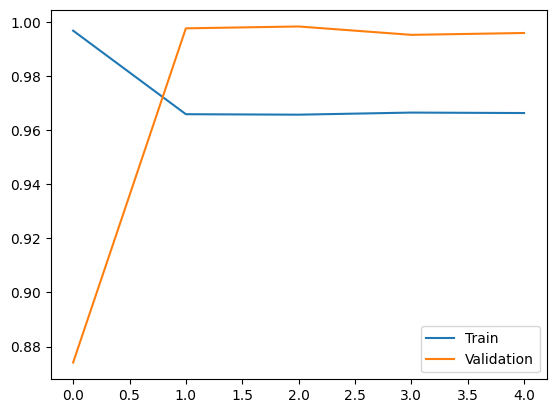

In [ ]:
plt.plot(range(fold), train_accuracy, range(fold), valid_accuracy)
plt.legend(['Train', 'Validation'],loc='best')
plt.show()

In [ ]:
print_model_result(gradboost)

Result of df_train:

                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.95      0.94      2523
      Normal_Weight       0.89      0.90      0.89      3082
     Obesity_Type_I       0.91      0.90      0.90      2910
    Obesity_Type_II       0.97      0.98      0.97      3248
   Obesity_Type_III       1.00      1.00      1.00      4046
 Overweight_Level_I       0.84      0.80      0.82      2427
Overweight_Level_II       0.84      0.85      0.84      2522

           accuracy                           0.92     20758
          macro avg       0.91      0.91      0.91     20758
       weighted avg       0.92      0.92      0.92     20758

[[2387  127    0    1    0    6    2]
 [ 147 2774    3    0    0  136   22]
 [   3    4 2605   91   12   55  140]
 [   0    0   48 3182    3    1   14]
 [   1    0    4    3 4035    3    0]
 [  13  179   48    0    0 1945  242]
 [   0   38  151   20    0  175 2138]]
Result of df_extra:

                 

In [ ]:
import pickle
with open("output/models/gradboost_1.pkl",'wb')as f:
    pickle.dump(gradboost, f)

In [ ]:
def print_model_result(model):
    pred = model.predict(preprocessor.transform(df_train.drop(target_feature, axis=1)))
    train_report = classification_report(df_train[target_feature], pred)
    train_matrix = confusion_matrix(df_train[target_feature], pred)
    print("Result of df_train:\n")
    print(train_report)
    print(train_matrix)
    pred = model.predict(preprocessor.transform(df_extra.drop(target_feature, axis=1)))
    test_report = classification_report(df_extra[target_feature], pred)
    test_matrix = confusion_matrix(df_extra[target_feature], pred)
    print("Result of df_extra:\n")
    print(test_report)
    print(test_matrix)


In [ ]:
res_ = {
    'trial_id'  : [],
    'accuracy'  : [],
    'margin'    : [],
    'params'    : [],
}
for trial in study.best_trials:
    res_['trial_id'].append(trial.number)
    res_['params'].append(trial.params)
    res_['accuracy'].append(trial.values[0])
    res_['margin'].append(trial.values[1])

result_df = pd.DataFrame(res_)
select_cols = ['trial_id', 'accuracy', 'test_acc', 'margin', 'params']
result_df['test_acc'] = result_df['accuracy'] + result_df['margin']
result_df = result_df[select_cols]

In [ ]:
result_df.sort_values(['accuracy','margin'], ascending=[False, False]).reset_index(drop=True)

In [ ]:
result_df.sort_values(['test_acc','margin'], ascending=[False, False]).reset_index(drop=True)

## Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter=500,multi_class='ovr', random_state=42)
lr.fit(X_train,y_train)

LogisticRegression(max_iter=500, multi_class='ovr', random_state=42)

In [ ]:
lr.score(X_train,y_train), lr.score(X_test,y_test)

(0.7119856887298748, 0.7177717129555305)

## Gradient Boosting re-run

In [ ]:
import optuna
def objective(trial):
    params = {
        'loss'                  : trial.suggest_categorical('loss', ['log_loss']),
        'learning_rate'         : trial.suggest_float('learning_rate', .01, .1, log=True ),
        'subsample'             : trial.suggest_float('subsample', 0.1,1,log=True),
        'max_depth'             : trial.suggest_int('max_depth', 3, 6, log=True),
        'min_samples_split'     : trial.suggest_int('min_samples_split', 10, 100, log=True),
        'min_samples_leaf'      : trial.suggest_int('min_samples_leaf', 10, 100, log=True),
        'max_features'          : trial.suggest_categorical('max_features', ['sqrt','log2', 4, 8, 12, None]),
        'init'                  : trial.suggest_categorical('init', [lr,'zero', None]),
        'validation_fraction'   : trial.suggest_float('validation_fraction',.1,.3,step=.05),
        'n_iter_no_change'      : trial.suggest_categorical('n_iter_no_change',[5,10,15,20]),
        'tol'                   : trial.suggest_categorical('tol', [1e-5, 1e-4,1e-3]),
        'ccp_alpha'             : trial.suggest_float('ccp_alpha', .001, 100, log=True),
        'min_impurity_decrease' : trial.suggest_float('min_impurity_decrease', .00001, .1, log=True),

    }
    margin = 0
    try:
        clf = GradientBoostingClassifier(**params,random_state=42)
        clf.fit(X_train, y_train)
        margin = accuracy_score(y_test,clf.predict(X_test))
    except Exception as e:
        margin = 0
    return margin
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=500)

[I 2024-02-05 01:43:44,904] A new study created in memory with name: no-name-a7dfecce-5b64-4401-b4ef-5b0a08a15d8e
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains LogisticRegression(max_iter=500, multi_class='ovr', random_state=42) which is of type LogisticRegression.

[I 2024-02-05 01:43:50,966] Trial 0 finished with value: 0.1684058436346123 and parameters: {'loss': 'log_loss', 'learning_rate': 0.04832570950363902, 'subsample': 0.6142003826744714, 'max_depth': 3, 'min_samples_split': 31, 'min_samples_leaf': 17, 'max_features': None, 'init': 'zero', 'validation_fraction': 0.3, 'n_iter_no_change': 10, 'tol': 0.0001, 'ccp_alpha': 14.972630374932468, 'min_impurity_decrease': 0.00884089264596462}. Best is trial 0 with value: 0.1684058436346123.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning:

Choi

In [ ]:
parameters = {'loss': 'log_loss', 'learning_rate': 0.1,
              'subsample': 0.9,
              'max_depth': 6, 'min_samples_split': 24,
              'min_samples_leaf': 50,
              'max_features': None, 'init': None, 'validation_fraction': 0.1,
            #   'n_iter_no_change': 15, 'tol': 0.0001,
              'ccp_alpha': 0.00100,
              'min_impurity_decrease': 0.0015
              }

gbm = GradientBoostingClassifier( **parameters, n_estimators=200, random_state=42)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.001, max_depth=6,
                           min_impurity_decrease=0.0015, min_samples_leaf=50,
                           min_samples_split=24, n_estimators=200,
                           random_state=42, subsample=0.9)

In [ ]:
gbm.n_estimators_

200

In [ ]:
gbm.score(X_train, y_train), gbm.score(X_test, y_test)

(0.8595706618962433, 0.8635414994381121)

In [ ]:
pred = gbm.predict(X_train)
train_report = classification_report(y_train, pred)
train_matrix = confusion_matrix(y_train, pred)
print("Result of df_train:\n")
print(train_report)
print(train_matrix)
pred = gbm.predict(X_test)
test_report = classification_report(y_test, pred)
test_matrix = confusion_matrix(y_test, pred)
print("Result of df_extra:\n")
print(test_report)
print(test_matrix)

Result of df_train:

                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.91      0.91      2523
      Normal_Weight       0.80      0.86      0.83      3082
     Obesity_Type_I       0.85      0.83      0.84      2910
    Obesity_Type_II       0.95      0.96      0.96      3248
   Obesity_Type_III       0.99      1.00      0.99      4046
 Overweight_Level_I       0.75      0.71      0.73      2427
Overweight_Level_II       0.75      0.73      0.74      2522

           accuracy                           0.87     20758
          macro avg       0.86      0.86      0.86     20758
       weighted avg       0.87      0.87      0.87     20758

[[2301  214    0    1    0    5    2]
 [ 221 2645    5    0    0  183   28]
 [   3    7 2410  131   28   65  266]
 [   0    0   93 3131    3    3   18]
 [   1    0    3    4 4035    3    0]
 [  14  355   51    0    0 1715  292]
 [   0   84  265   17    0  324 1832]]
Result of df_extra:

                 

In [ ]:
import pickle
with open('output/models/GradBoost_2.pkl','wb')as f:
    pickle.dump(gbm,f)


## Run this first

In [ ]:
df = df_total.copy()
df_processed = pd.DataFrame(preprocessor.fit_transform(df.drop(target_feature,axis=1)), columns = df.columns[:-1])
X_train,X_test,y_train,y_test = train_test_split(np.array(df_processed), np.array(df[target_feature]),
                                                 test_size=.3,random_state=42)
def get_result(model):
    pred = model.predict(X_train)
    train_report = classification_report(y_train, pred)
    train_matrix = confusion_matrix(y_train, pred)
    print("Result of df_train:\n")
    print(train_report)
    print(train_matrix)
    pred = model.predict(X_test)
    test_report = classification_report(y_test, pred)
    test_matrix = confusion_matrix(y_test, pred)
    print("Result of df_extra:\n")
    print(test_report)
    print(test_matrix)

In [ ]:
ohe = OneHotEncoder(drop = 'first', sparse_output=False)
x = ohe.fit_transform(df[['CALC']])
x

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

## LGBMClassifier

In [ ]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

In [ ]:
lgbm.score(X_train, y_train), lgbm.score(X_test, y_test)

(0.9697261593504886, 0.8972547760475197)

In [ ]:
def objective(trial):
    params = {
        'boosting_type'     : trial.suggest_categorical('boosting_type',
                                                    ['gbdt', 'rf', 'dart']),
        'num_leaves'        : trial.suggest_int('num_leaves', 8, 64, log=True),
        'max_depth'         : trial.suggest_categorical('max_depth', [-1, 3, 4, 5, 6]),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.01, 1,log=True),
        'objective'         : trial.suggest_categorical('objective', ['multiclass', 'multiclass_ova'] ),

        'min_split_gain'    : trial.suggest_categorical('min_split_gain', [0, 1e-4, 1e-3, 1e-1] ),
        'min_child_samples' : trial.suggest_categorical('min_child_samples', [10, 15, 20, 25, 30] ),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree',[ .4, .5, .67, .75, .9, 1.0]),
        'reg_alpha'         : trial.suggest_float('reg_alpha', 0.001, 1, log=True),
        'reg_lambda'        : trial.suggest_float('reg_lambda', 0.001, 1, log=True ),
        'importance_type'   : trial.suggest_categorical('importance_type', ['split', 'gain'] ),

    }
    train_acc = 0
    margin = 0
    try:
        clf = LGBMClassifier(**params,random_state=42, verbose=0)
        clf.fit(X_train, y_train)
        train_acc = accuracy_score(y_train,clf.predict(X_train))
        margin = accuracy_score(y_test,clf.predict(X_test)) - train_acc
    except Exception as e:
        margin = 0
    return train_acc, margin

study = optuna.create_study(directions=['maximize','maximize'])
study.optimize(objective,n_trials=500)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
study.best_params

{'boosting_type': 'gbdt',
 'num_leaves': 36,
 'max_depth': -1,
 'learning_rate': 0.09286852743112695,
 'objective': 'multiclass',
 'min_split_gain': 0,
 'min_child_samples': 30,
 'colsample_bytree': 0.4,
 'reg_alpha': 0.18230105168869265,
 'reg_lambda': 0.14526290461623712,
 'importance_type': 'gain'}

In [ ]:
study.best_value

0.9057633649060844

In [ ]:
params = {'boosting_type': 'gbdt',
 'num_leaves': 36,
 'max_depth': -1,
 'learning_rate': 0.09286852743112695,
 'objective': 'multiclass',
 'min_split_gain': 0,
 'min_child_samples': 30,
 'colsample_bytree': 0.4,
 'reg_alpha': 0.18230105168869265,
 'reg_lambda': 0.14526290461623712,
 'importance_type': 'gain'}

params = {'boosting_type': 'dart', 'num_leaves': 12, 'max_depth': 4,
          'learning_rate': 0.3054447860783148, 'objective': 'multiclass',
          'min_split_gain': 0.0001, 'min_child_samples': 10,
          'colsample_bytree': 0.4,
          'reg_alpha': 0.10004378660875315,
          'reg_lambda': 0.6813742183318174, 'importance_type': 'split'}

lgbm = LGBMClassifier(**params,random_state=42)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 383
[LightGBM] [Info] Number of data points in the train set: 14534, number of used features: 16
[LightGBM] [Info] Start training from score -2.030959
[LightGBM] [Info] Start training from score -1.822075
[LightGBM] [Info] Start training from score -1.877183
[LightGBM] [Info] Start training from score -1.820800
[LightGBM] [Info] Start training from score -2.044156
[LightGBM] [Info] Start training from score -2.044687
[LightGBM] [Info] Start training from score -2.015350
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

LGBMClassifier(boosting_type='dart', colsample_bytree=0.4,
               learning_rate=0.3054447860783148, max_depth=4,
               min_child_samples=10, min_split_gain=0.0001, num_leaves=12,
               objective='multiclass', random_state=42,
               reg_alpha=0.10004378660875315, reg_lambda=0.6813742183318174)

In [ ]:
lgbm.score(X_train, y_train), lgbm.score(X_test, y_test)

(0.9166781340305491, 0.900305024883609)

In [ ]:
lgbm.score(X_train, y_train), lgbm.score(X_test, y_test)

(0.9166781340305491, 0.900305024883609)

In [ ]:
get_result(lgbm)

Result of df_train:

                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.95      0.94      1907
      Normal_Weight       0.89      0.91      0.90      2350
     Obesity_Type_I       0.91      0.91      0.91      2224
    Obesity_Type_II       0.97      0.98      0.97      2353
   Obesity_Type_III       0.99      1.00      1.00      1882
 Overweight_Level_I       0.86      0.81      0.84      1881
Overweight_Level_II       0.84      0.86      0.85      1937

           accuracy                           0.92     14534
          macro avg       0.92      0.92      0.92     14534
       weighted avg       0.92      0.92      0.92     14534

[[1805   95    1    1    0    4    1]
 [ 104 2128    2    0    0   91   25]
 [   2    1 2019   49    9   40  104]
 [   0    0   37 2301    1    0   14]
 [   1    0    1    4 1875    1    0]
 [   9  126   36    0    0 1533  177]
 [   0   32  113   12    0  118 1662]]
Result of df_extra:

                 

In [ ]:
import pickle
with open('output/models/LGBM_1.pkl','wb')as f:
    pickle.dump(lgbm,f)

## Distinct Cluster

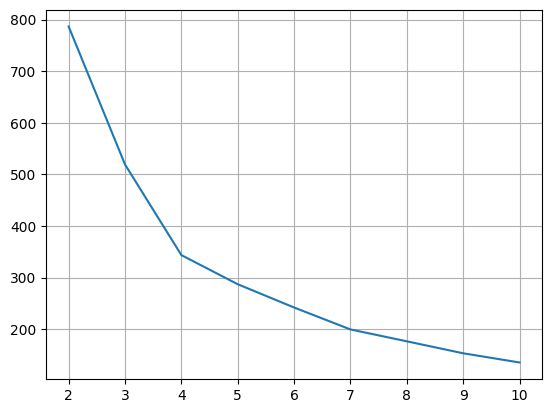

In [ ]:
from sklearn.cluster import KMeans
clusters = []
inertia = []
for i in range(2,11):
    cluster = KMeans(n_clusters=i,init='k-means++',n_init=4, random_state = 42)
    X = pd.DataFrame(X_train.copy(), columns = df.columns[:-1])
    cluster.fit(X[num_features])
    clusters.append(i)
    inertia.append(cluster.inertia_)
plt.plot(clusters,inertia)
plt.grid()
plt.show()

In [ ]:
cluster = KMeans(n_clusters=4,init='k-means++',n_init=4, random_state = 42)
X = pd.DataFrame(X_train.copy(), columns = df.columns[:-1])
cluster.fit(X[num_features])
X['Target'] = y_train
X["Label"] = cluster.labels_
X.groupby(['Label','Target'])['Target'].count()

Label  Target             
0      Insufficient_Weight     694
       Normal_Weight          1069
       Obesity_Type_I          407
       Obesity_Type_II         169
       Overweight_Level_I      830
       Overweight_Level_II    1057
1      Insufficient_Weight    1211
       Normal_Weight          1251
       Obesity_Type_I          898
       Obesity_Type_II           4
       Obesity_Type_III          4
       Overweight_Level_I      850
       Overweight_Level_II     576
2      Insufficient_Weight       2
       Normal_Weight            29
       Obesity_Type_I          846
       Obesity_Type_II        2177
       Obesity_Type_III          5
       Overweight_Level_I      193
       Overweight_Level_II     297
3      Normal_Weight             1
       Obesity_Type_I           73
       Obesity_Type_II           3
       Obesity_Type_III       1873
       Overweight_Level_I        8
       Overweight_Level_II       7
Name: Target, dtype: int64

## First abridged model calculated

In [ ]:
df = df_train.copy()
# df = df_extra.copy()

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline(steps = [('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())
                                 ])


cat_pipeline = Pipeline(steps= [('imputer', SimpleImputer(strategy='most_frequent')),
                                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
                                ('scaler',StandardScaler())
                                ])

mapper = {  'Normal_Weight'         : 0,
            'Overweight_Level_I'    : 1,
            'Overweight_Level_II'   : 2,
            'Obesity_Type_I'        : 3,
            'Insufficient_Weight'   : 4,
            'Obesity_Type_II'       : 5,
            'Obesity_Type_III'      : 6
        }

# preprocessor
X_train, X_test, y_train, y_test = train_test_split(df.drop(target_feature, axis=1),
                                df[target_feature].map(mapper), random_state=42)
preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_features),
    ('cat_pipeline', cat_pipeline, cat_features)
])

X_train_scaled = pd.DataFrame(preprocessor.fit_transform(X_train))
X_test_scaled = pd.DataFrame(preprocessor.transform(X_test))


In [ ]:
algos = [
        #  SVC(), NuSVC(), LinearSVC(),
         LogisticRegression(),
         DecisionTreeClassifier(), ExtraTreeClassifier(),
         AdaBoostClassifier(), ExtraTreesClassifier(),
         BaggingClassifier(), RandomForestClassifier(),
         GradientBoostingClassifier(),
         HistGradientBoostingClassifier(),
         LGBMClassifier(), XGBClassifier(), XGBRFClassifier(),
         CatBoostClassifier()
         ]
names = list(map(lambda x: x.__class__.__name__, algos))


In [ ]:
%%time
history = { 'algo_name': names,
            'train_acc_score' : [],
            'test_acc_score' : [],
            'train_roc'  : [],
            'test_roc'  : [],
            }

for model in algos:
    print(f"{str(model)[:-2]} has started!")
    model.fit(X_train_scaled, y_train)
    pred_train = model.predict(X_train_scaled)
    pred_test =  model.predict(X_test_scaled)
    history['train_acc_score'].append(accuracy_score(y_train, pred_train))
    history['test_acc_score'].append(accuracy_score(y_test, pred_test))
    try:
        y_prob = model.predict_proba(X_train_scaled)[:,1]
        score = roc_auc_score(y_train, y_prob)
        history['train_roc'].append(score)
        y_prob = model.predict_proba(X_test_scaled)[:,1]
        score = roc_auc_score(y_test, y_prob)
        history['test_roc'].append(score)
    except Exception as e:
        history['train_roc'].append(np.nan)
        history['test_roc'].append(np.nan)

display.clear_output()

CPU times: user 1min 25s, sys: 1.86 s, total: 1min 27s
Wall time: 1min 6s


In [ ]:
temp = pd.DataFrame(history)
select_cols = ['algo_name', 'train_acc_score', 'test_acc_score', 'overfitted_score', 'average_score']
temp['overfitted_score'] = temp['train_acc_score'] - temp['test_acc_score']
temp['average_score'] = (temp['train_acc_score'] + temp['test_acc_score'])/2

temp = temp.sort_values(['test_acc_score', 'train_acc_score', 'overfitted_score'],
            ascending =[False, False, True]).reset_index(drop=True)[select_cols]
temp.to_csv("output/history_sorted_by_test.csv",index=False)
temp

algo_name  train_acc_score  test_acc_score  \
0               CatBoostClassifier         0.954843        0.902697   
1                    XGBClassifier         0.976362        0.900385   
2       GradientBoostingClassifier         0.916817        0.899229   
3   HistGradientBoostingClassifier         0.940712        0.899037   
4                   LGBMClassifier         0.969874        0.896339   
5                BaggingClassifier         0.991714        0.881888   
6                  XGBRFClassifier         0.891444        0.880347   
7           RandomForestClassifier         0.999743        0.869942   
8               LogisticRegression         0.870504        0.862813   
9           DecisionTreeClassifier         0.999807        0.844894   
10            ExtraTreesClassifier         0.999807        0.810790   
11             ExtraTreeClassifier         0.999807        0.750289   
12              AdaBoostClassifier         0.419964        0.426204   

    overfitted_score  average_score  
0           0.052146       0.928770  
1           0.075976       0.938374  
2           0.017587       0.908023  
3           0.041675       0.919874  
4           0.073535       0.933107  
5           0.109826       0.936801  
6           0.011097       0.885895  
7           0.129801       0.934843  
8           0.007690       0.866658  
9           0.154913       0.922351  
10          0.189017       0.905299  
11          0.249518       0.875048  
12         -0.006240       0.423084

In [ ]:
temp = pd.DataFrame(history)
select_cols = ['algo_name', 'train_acc_score', 'test_acc_score', 'overfitted_score', 'average_score']
temp['overfitted_score'] = temp['train_acc_score'] - temp['test_acc_score']
temp['average_score'] = (temp['train_acc_score'] + temp['test_acc_score'])/2
temp = temp.sort_values(['train_acc_score', 'test_acc_score', 'overfitted_score'],
            ascending =[False, False, True]).reset_index(drop=True)[select_cols]
temp.to_csv("output/history_sorted_by_train.csv",index=False)
temp

algo_name  train_acc_score  test_acc_score  \
0           DecisionTreeClassifier         0.999807        0.844894   
1             ExtraTreesClassifier         0.999807        0.810790   
2              ExtraTreeClassifier         0.999807        0.750289   
3           RandomForestClassifier         0.999743        0.869942   
4                BaggingClassifier         0.991714        0.881888   
5                    XGBClassifier         0.976362        0.900385   
6                   LGBMClassifier         0.969874        0.896339   
7               CatBoostClassifier         0.954843        0.902697   
8   HistGradientBoostingClassifier         0.940712        0.899037   
9       GradientBoostingClassifier         0.916817        0.899229   
10                 XGBRFClassifier         0.891444        0.880347   
11              LogisticRegression         0.870504        0.862813   
12              AdaBoostClassifier         0.419964        0.426204   

    overfitted_score  average_score  
0           0.154913       0.922351  
1           0.189017       0.905299  
2           0.249518       0.875048  
3           0.129801       0.934843  
4           0.109826       0.936801  
5           0.075976       0.938374  
6           0.073535       0.933107  
7           0.052146       0.928770  
8           0.041675       0.919874  
9           0.017587       0.908023  
10          0.011097       0.885895  
11          0.007690       0.866658  
12         -0.006240       0.423084

In [ ]:
temp = pd.DataFrame(history)
select_cols = ['algo_name', 'train_acc_score', 'test_acc_score', 'overfitted_score', 'average_score']
temp['overfitted_score'] = temp['train_acc_score'] - temp['test_acc_score']
temp['average_score'] = (temp['train_acc_score'] + temp['test_acc_score'])/2
temp = temp.sort_values(['average_score', 'overfitted_score', 'test_acc_score',],
            ascending =[False, True, False]).reset_index(drop=True)[select_cols]
temp.to_csv("output/history_sorted_by_avg.csv",index=False)
temp

algo_name  train_acc_score  test_acc_score  \
0                    XGBClassifier         0.976362        0.900385   
1                BaggingClassifier         0.991714        0.881888   
2           RandomForestClassifier         0.999743        0.869942   
3                   LGBMClassifier         0.969874        0.896339   
4               CatBoostClassifier         0.954843        0.902697   
5           DecisionTreeClassifier         0.999807        0.844894   
6   HistGradientBoostingClassifier         0.940712        0.899037   
7       GradientBoostingClassifier         0.916817        0.899229   
8             ExtraTreesClassifier         0.999807        0.810790   
9                  XGBRFClassifier         0.891444        0.880347   
10             ExtraTreeClassifier         0.999807        0.750289   
11              LogisticRegression         0.870504        0.862813   
12              AdaBoostClassifier         0.419964        0.426204   

    overfitted_score  average_score  
0           0.075976       0.938374  
1           0.109826       0.936801  
2           0.129801       0.934843  
3           0.073535       0.933107  
4           0.052146       0.928770  
5           0.154913       0.922351  
6           0.041675       0.919874  
7           0.017587       0.908023  
8           0.189017       0.905299  
9           0.011097       0.885895  
10          0.249518       0.875048  
11          0.007690       0.866658  
12         -0.006240       0.423084

In [ ]:
%%time
pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.
param_grid = [

    {'classifier' : [RandomForestClassifier()],
     'classifier__criterion' : ['gini', 'entropy', 'log_loss'],
     'classifier__n_estimators' : list(range(10,101,10)),
     'classifier__max_features' : list(range(6,32,5))},

]

# Create grid search object
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs= -1)

# Fit on data
best_clf = clf.fit(X_train_scaled, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",best_clf.best_estimator_)
print("\n The best score across ALL searched params:\n",best_clf.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('classifier',
                 RandomForestClassifier(criterion='log_loss', max_features=31,
                                        n_estimators=90))])

 The best score across ALL searched params:
 0.8968405639763306

 The best parameters across ALL searched params:
 {'classifier': RandomForestClassifier(criterion='log_loss', max_features=31, n_estimators=90), 'classifier__criterion': 'log_loss', 'classifier__max_features': 31, 'classifier__n_estimators': 90}
CPU times: user 22.3 s, sys: 3.63 s, total: 25.9 s
Wall time: 20min 7s


In [ ]:
print(classification_report(y_train, best_clf.predict(X_train_scaled)))
print(classification_report(y_test, best_clf.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2302
           1       1.00      1.00      1.00      1816
           2       1.00      1.00      1.00      1890
           3       1.00      1.00      1.00      2225
           4       1.00      1.00      1.00      1883
           5       1.00      1.00      1.00      2423
           6       1.00      1.00      1.00      3029

    accuracy                           1.00     15568
   macro avg       1.00      1.00      1.00     15568
weighted avg       1.00      1.00      1.00     15568

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       780
           1       0.75      0.78      0.77       611
           2       0.79      0.78      0.79       632
           3       0.87      0.86      0.87       685
           4       0.94      0.93      0.93       640
           5       0.96      0.97      0.96       825
           6       1.00 

## Load and update model

In [ ]:
mapper = {  'Normal_Weight'         : 0,
            'Overweight_Level_I'    : 1,
            'Overweight_Level_II'   : 2,
            'Obesity_Type_I'        : 3,
            'Insufficient_Weight'   : 4,
            'Obesity_Type_II'       : 5,
            'Obesity_Type_III'      : 6
        }
rev_mapper = {  0: 'Normal_Weight'         ,
                1: 'Overweight_Level_I'    ,
                2: 'Overweight_Level_II'   ,
                3: 'Obesity_Type_I'        ,
                4: 'Insufficient_Weight'   ,
                5: 'Obesity_Type_II'       ,
                6: 'Obesity_Type_III'
        }

In [ ]:
import os
from scipy.stats import mode
result = pd.DataFrame()

for filename in os.listdir('output/models/'):
    if filename in set(['CatBoost.pkl',]):
        with open('output/models/'+filename,'rb')as f:
            model = pickle.load(f)
            result['CatBoost'] = model.predict(df_train.drop(target_feature, axis=1))
    else:
        with open('output/models/'+filename,'rb') as f:
            model = pickle.load(f)
            result[filename[:-4]] = model.predict(preprocessor.transform(df_train.drop(target_feature, axis=1)))


result['Target'] = df_train[target_feature]
result['Predicted'] = pd.Series(mode(result.drop('Target',axis=1).replace(mapper),axis=1).mode).map(rev_mapper)
result.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



gradboost_1        decision_tree             CatBoost  \
0  Overweight_Level_II  Overweight_Level_II  Overweight_Level_II   
1        Normal_Weight        Normal_Weight        Normal_Weight   
2  Insufficient_Weight  Insufficient_Weight  Insufficient_Weight   
3     Obesity_Type_III     Obesity_Type_III     Obesity_Type_III   
4  Overweight_Level_II  Overweight_Level_II  Overweight_Level_II   

                Target            Predicted  
0  Overweight_Level_II  Overweight_Level_II  
1        Normal_Weight        Normal_Weight  
2  Insufficient_Weight  Insufficient_Weight  
3     Obesity_Type_III     Obesity_Type_III  
4  Overweight_Level_II  Overweight_Level_II

In [ ]:
result[result['Target']!=result['Predicted']]

gradboost_1        decision_tree             CatBoost  \
8       Overweight_Level_I        Normal_Weight        Normal_Weight   
10      Overweight_Level_I        Normal_Weight        Normal_Weight   
35     Overweight_Level_II  Overweight_Level_II   Overweight_Level_I   
84          Obesity_Type_I      Obesity_Type_II      Obesity_Type_II   
90     Overweight_Level_II  Overweight_Level_II  Overweight_Level_II   
...                    ...                  ...                  ...   
20631   Overweight_Level_I       Obesity_Type_I       Obesity_Type_I   
20673  Overweight_Level_II   Overweight_Level_I   Overweight_Level_I   
20715   Overweight_Level_I        Normal_Weight        Normal_Weight   
20725       Obesity_Type_I       Obesity_Type_I       Obesity_Type_I   
20732       Obesity_Type_I       Obesity_Type_I       Obesity_Type_I   

                    Target            Predicted  
8       Overweight_Level_I        Normal_Weight  
10      Overweight_Level_I        Normal_Weight  
35      Overweight_Level_I  Overweight_Level_II  
84          Obesity_Type_I      Obesity_Type_II  
90          Obesity_Type_I  Overweight_Level_II  
...                    ...                  ...  
20631   Overweight_Level_I       Obesity_Type_I  
20673  Overweight_Level_II   Overweight_Level_I  
20715   Overweight_Level_I        Normal_Weight  
20725  Overweight_Level_II       Obesity_Type_I  
20732  Overweight_Level_II       Obesity_Type_I  

[1439 rows x 5 columns]

In [ ]:
accuracy_score(result['Target'],result['CatBoost'])

0.9176702957895752

In [ ]:
(len(df_train)+len(df_extra))-len(df_total)

2106

In [ ]:
mode(result.drop('Target',axis=1).replace(mapper),axis=1).mode

array([2, 0, 4, ..., 5, 2, 5])

In [ ]:
with mlflow.start_run():
    mlflow.log_artifact('output/models')

In [ ]:
result['Predicted'] = np.max(result.drop('Target',axis=1),axis=1)

0.8621736198092301

In [ ]:
with mlflow.start_run():
    mlflow.log_artifact('output/models/')

## Prediction and Submission

In [ ]:
submission = pd.read_csv("sample_submission.csv")
submission[target_feature] = gradboost.predict(preprocessor.transform(df_test.drop('id',axis=1)))
submission.to_csv('submission.csv',index=False)
submission.head()

id          NObeyesdad
0  20758     Obesity_Type_II
1  20759  Overweight_Level_I
2  20760    Obesity_Type_III
3  20761      Obesity_Type_I
4  20762    Obesity_Type_III

In [ ]:
!kaggle competitions submit -c playground-series-s4e2 -f submission.csv -m "cat_model_2.pkl:masked-foal-364"

100% 312k/312k [00:00<00:00, 425kB/s]
Successfully submitted to Multi-Class Prediction of Obesity Risk

## BMR prediction

In [15]:
df = df_train.copy()

df['FCVC']=df['FCVC'].round(0)
df['NCP']=df['NCP'].round(0)
df['CH2O']=df['CH2O'].round(0)
df['FAF']=df['FAF'].round(0)
df['TUE']=df['TUE'].round(0)
#Encoding Categorical columns

df = pd.get_dummies(df,prefix=['Gender'], columns = ['Gender'], drop_first=True)
df = pd.get_dummies(df,prefix=['family_history_with_overweight_'], columns = ['family_history_with_overweight'], drop_first=True)
df = pd.get_dummies(df,prefix=['FAVC'], columns = ['FAVC'], drop_first=True)
df = pd.get_dummies(df,prefix=['FCVC'], columns = ['FCVC'], drop_first=False)
df = pd.get_dummies(df,prefix=['NCP'], columns = ['NCP'], drop_first=False)
df = pd.get_dummies(df,prefix=['CAEC'], columns = ['CAEC'], drop_first=False)
df = pd.get_dummies(df,prefix=['SMOKE'], columns = ['SMOKE'], drop_first=True)
df = pd.get_dummies(df,prefix=['CH2O'], columns = ['CH2O'], drop_first=False)
df = pd.get_dummies(df,prefix=['SCC'], columns = ['SCC'], drop_first=True)
df = pd.get_dummies(df,prefix=['FAF'], columns = ['FAF'], drop_first=False)
df = pd.get_dummies(df,prefix=['CALC'], columns = ['CALC'], drop_first=False)
df = pd.get_dummies(df,prefix=['MTRANS'], columns = ['MTRANS'], drop_first=False)

# Target Column Wrong
df.pop('NObeyesdad')
# target =  df.pop('NObeyesdad').map(mapper)

df['BMI']=df['Weight']/(df['Height']*df['Height'])
df.loc[df['BMI']<18.50,'OBESITY']=0
df.loc[(df['BMI']>=18.50)&(df['BMI']<25),'OBESITY']=1
df.loc[(df['BMI']>=25)&(df['BMI']<30),'OBESITY']=2
df.loc[(df['BMI']>=30)&(df['BMI']<35),'OBESITY']=3
df.loc[(df['BMI']>=35)&(df['BMI']<40),'OBESITY']=4
df.loc[df['BMI']>=40,'OBESITY']=5
del df['BMI']

df3=df.copy()
scaler2 = StandardScaler()
df3[['Age','Height','Weight']]=scaler2.fit_transform(df3[['Age','Height','Weight']])
target=df3['OBESITY']
df3.pop('OBESITY')

# df3.pop('CALC_Always')
X_train, X_test, y_train, y_test = train_test_split(df3, target,
                                                    train_size=0.75, test_size=0.25,shuffle=True)

exported_pipeline = make_pipeline(
    SelectFromModel(estimator=ExtraTreesClassifier(criterion="gini", max_features=0.1, n_estimators=100), threshold=0.05),
    RFE(estimator=ExtraTreesClassifier(criterion="gini", max_features=0.4, n_estimators=100), step=0.6000000000000001),
    MaxAbsScaler(),
    StackingEstimator(estimator=MLPClassifier(alpha=0.1, learning_rate_init=0.5)),
    RobustScaler(),
    XGBClassifier(learning_rate=0.5, max_depth=7, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=0.8500000000000001, verbosity=0)
)
exported_pipeline.fit(X_train,y_train)
results = exported_pipeline.predict(X_test)

xx = df3.copy()
xx['predict'] = exported_pipeline.predict(xx)
xx['target'] = target
print(confusion_matrix(xx['target'], xx['predict']))
print(classification_report(xx['target'],xx['predict']))

[[2405    0    0    0    0    0]
 [   0 3527    3    0    0    0]
 [   0    0 4734    1    0    0]
 [   0    0    1 3137    0    0]
 [   0    0    0    3 3663    0]
 [   0    0    0    0    1 3283]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2405
         1.0       1.00      1.00      1.00      3530
         2.0       1.00      1.00      1.00      4735
         3.0       1.00      1.00      1.00      3138
         4.0       1.00      1.00      1.00      3666
         5.0       1.00      1.00      1.00      3284

    accuracy                           1.00     20758
   macro avg       1.00      1.00      1.00     20758
weighted avg       1.00      1.00      1.00     20758



In [16]:
exported_pipeline.fit(X_train,y_train)

Pipeline(steps=[('selectfrommodel',
                 SelectFromModel(estimator=ExtraTreesClassifier(max_features=0.1),
                                 threshold=0.05)),
                ('rfe',
                 RFE(estimator=ExtraTreesClassifier(max_features=0.4),
                     step=0.6000000000000001)),
                ('maxabsscaler', MaxAbsScaler()),
                ('stackingestimator',
                 StackingEstimator(estimator=MLPClassifier(alpha=0.1,
                                                           learning_rate_init=0.5))),
                ('robustscaler',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100, n_jobs=1,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])